In [1]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,\
      mean_squared_log_error, mean_absolute_error, make_scorer, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import shap

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.set_index('OSEBuildingID', inplace = True)

In [4]:
data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [41]:
cols = ['Age','PropertyGFATotal', 'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

Age
0.29753360879193896


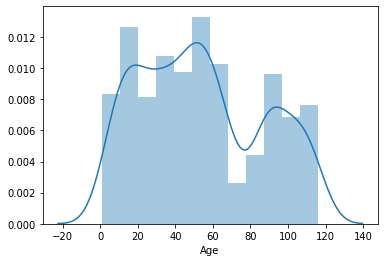

PropertyGFATotal
19.037917545145827


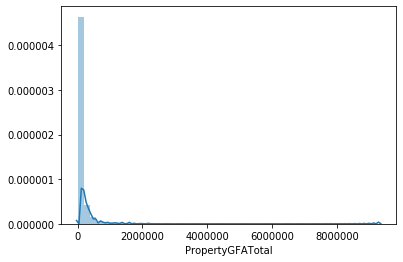

LargestPropertyUseTypeGFA
23.175161728669494


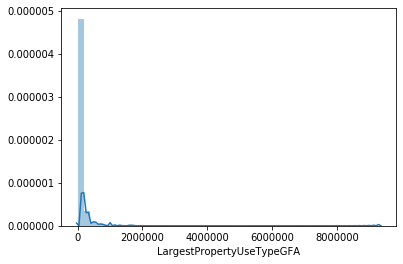

ENERGYSTARScore
0.07727154779048637


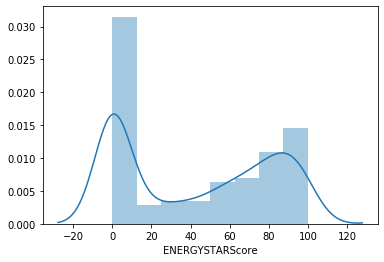

TotalGHGEmissions
14.130616835139792


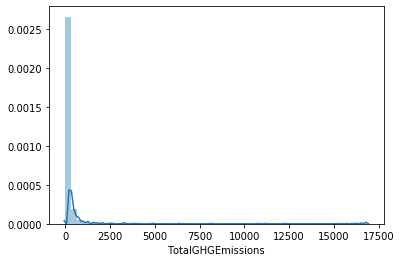

In [42]:
for col in cols:
      print(col)
      print(skew(data[col]))

      plt.figure()
      sns.distplot(data[col])
      plt.show()

In [7]:
cols = ['PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','PropertyGFATotal',
        'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

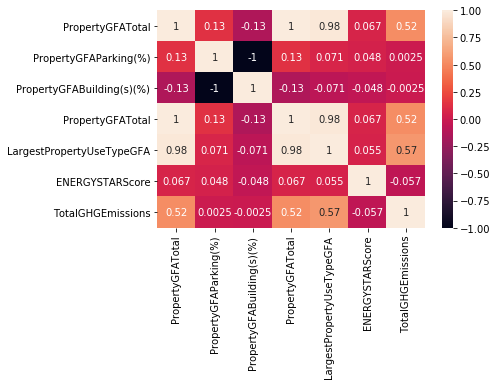

In [8]:
sns.heatmap(data[cols].corr(), annot = True)

In [9]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','LargestPropertyUseTypeGFA','ENERGYSTARScore','EnergyStarNaN',
        'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]


y = data['TotalGHGEmissions']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
colsk = ['NumberofFloors','PropertyGFATotal','LargestPropertyUseTypeGFA']

In [12]:
colsk = ['Age','PropertyGFATotal', 'LargestPropertyUseTypeGFA','ENERGYSTARScore']
X_train_tt = X_train.copy()
X_test_tt = X_test.copy()
X_train_tt[colsk] = np.log1p(X_train_tt[colsk])
X_test_tt[colsk] = np.log1p(X_test_tt[colsk])

In [13]:
std_scale = StandardScaler()
std_scale.fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
std_scale_tt = StandardScaler()
std_scale_tt.fit(X_train_tt)
X_train_tt = std_scale_tt.transform(X_train_tt)
X_test_tt = std_scale_tt.transform(X_test_tt)

In [14]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)
X_train_tt = pd.DataFrame(X_train_tt, columns = X.columns)
X_test_tt = pd.DataFrame(X_test_tt, columns = X.columns)

In [15]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_train, y_train)
baseline_error = mean_squared_error(y_test, dr.predict(y_test), squared=False)
baseline_error

770.5687305972889

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_error = mean_squared_error(y_test, lr.predict(X_test), squared=False)
lr_error

614.7720113903748

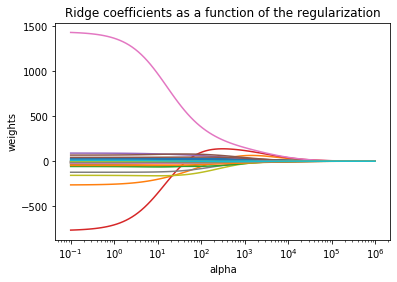

In [43]:
n_alphas = 100
alphas = np.logspace(-1, 6, n_alphas)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, mean_squared_error(y_test, ridge.predict(X_test), squared=False)])

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

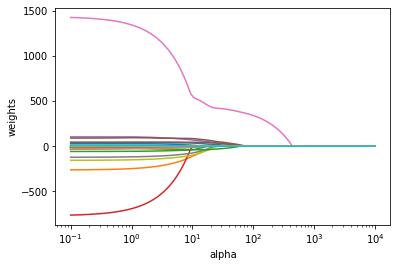

In [18]:
n_alphas = 100
alphas = np.logspace(-1, 4, n_alphas)
lasso = Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])


ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

In [21]:
def resultize(grid):

    res = pd.DataFrame(grid.cv_results_)
    res = res[['params', 'mean_fit_time', 'mean_test_RMSE', 
    'rank_test_RMSE', 'mean_test_MSE', 'rank_test_MSE', 
    'mean_test_MAE', 'rank_test_MAE', 'mean_test_R2', 'rank_test_R2']]
    res['mean_test_MSE'] = (-res[f'mean_test_MSE'])
    res['mean_test_RMSE'] = (-res[f'mean_test_RMSE'])
    res['mean_test_MAE'] = (-res[f'mean_test_MAE'])
    res.sort_values(by='rank_test_RMSE', inplace=True)
    return res

In [22]:
s = {'MSE': 'neg_mean_squared_error', 
      'RMSE': 'neg_root_mean_squared_error',
      'MAE': 'neg_mean_absolute_error',
      'R2': 'r2'}
score = 'RMSE'

In [23]:
params = {'alpha': np.logspace(0, 7, 20)}
grid_ridge = GridSearchCV(Ridge(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_ridge.fit(X_train, y_train)
grid_ridge_best_params = grid_ridge.best_params_
resultize(grid_ridge).head()

,params,mean_fit_time,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
8,{'alpha': 885.8667904100823},0.000995,476.639195,1,391733.232026,1,158.033462,1,0.174566,2
7,{'alpha': 379.26901907322497},0.001181,499.014277,2,399812.073361,2,166.462100,2,0.098645,4
9,{'alpha': 2069.138081114788},0.001097,516.894437,3,430045.350869,3,167.498079,3,0.175937,1
10,{'alpha': 4832.930238571752},0.001032,554.135987,4,478036.314766,4,181.645970,4,0.121211,3
6,{'alpha': 162.3776739188721},0.001165,558.543953,5,487951.291381,5,183.185330,5,-0.068267,7


In [24]:
grid_ridge_best_params ={'alpha': 885.8667904100823}

In [25]:
ridge = Ridge(**grid_ridge_best_params)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_error = mean_squared_error(y_test, y_pred, squared=False)
ridge_error

672.8791568764291

In [26]:
params = {"alpha": np.logspace(-1, 3, 30)}
grid_lasso = GridSearchCV(Lasso(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_lasso.fit(X_train, y_train)
grid_lasso_best_params = grid_lasso.best_params_
resultize(grid_lasso).head()

,params,mean_fit_time,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
22,{'alpha': 108.2636733874054},0.001117,482.539769,1,390921.906220,2,166.906055,3,0.155596,1
21,{'alpha': 78.80462815669912},0.000886,488.342255,2,390012.762722,1,165.871353,2,0.137284,3
20,{'alpha': 57.361525104486816},0.001081,512.534425,3,409277.421348,3,165.864468,1,0.111911,4
23,{'alpha': 148.73521072935117},0.001242,519.468991,4,423490.886398,4,174.215708,6,0.142675,2
19,{'alpha': 41.753189365604},0.001138,549.353859,5,468634.669624,5,168.319308,4,0.054916,6


In [27]:
grid_lasso_best_params = {'alpha': 108.2636733874054}

In [28]:
lasso = Lasso(**grid_lasso_best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso_error = mean_squared_error(y_test, y_pred, squared=False)
lasso_error

681.1888577167889

In [27]:
"""tt_ridge = TransformedTargetRegressor(regressor = Ridge(),
                               func = np.log1p,
                               inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(0, 7, 100)}
grid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_ridge.fit(X_train_tt, y_train)
grid_tt_ridge_best_params = grid_tt_ridge.best_params_
resultize(grid_tt_ridge).head()"""
#10s

"tt_ridge = TransformedTargetRegressor(regressor = Ridge(),\n                               func = np.log1p,\n                               inverse_func = np.expm1)\nparams = {'regressor__alpha': np.logspace(0, 7, 100)}\ngrid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)\ngrid_tt_ridge.fit(X_train_tt, y_train)\ngrid_tt_ridge_best_params = grid_tt_ridge.best_params_\nresultize(grid_tt_ridge).head()"

In [29]:
grid_tt_ridge_best_params = {'alpha': 413.20124001153346}

In [30]:
tt_ridge = TransformedTargetRegressor(regressor = Ridge(**grid_tt_ridge_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ridge.fit(X_train_tt, y_train)
y_pred = tt_ridge.predict(X_test_tt)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

700.6454542940965

In [31]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(-1, 3, 30)}
grid_tt_lasso = GridSearchCV(tt_lasso, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_lasso.fit(X_train_tt, y_train)
grid_tt_lasso_best_params = grid_tt_lasso.best_params_
resultize(grid_tt_lasso).head()

,params,mean_fit_time,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
0,{'regressor__alpha': 0.1},0.001565,536.687857,1,462738.098068,1,132.942363,1,0.253554,1
1,{'regressor__alpha': 0.1373823795883263},0.001390,552.682849,2,482857.093361,2,136.263267,2,0.215581,2
2,{'regressor__alpha': 0.18873918221350972},0.001355,566.970274,3,500886.212873,3,140.047820,3,0.171544,3
3,{'regressor__alpha': 0.2592943797404667},0.001339,582.248423,4,521877.406369,4,143.951297,4,0.123957,4
4,{'regressor__alpha': 0.3562247890262442},0.001310,595.817526,5,542045.154172,5,147.414285,5,0.081525,5


In [32]:
grid_tt_lasso_best_params = {'alpha': 0.1}

In [33]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(**grid_tt_lasso_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_lasso.fit(X_train_tt, y_train)
y_pred = tt_lasso.predict(X_test_tt)
tt_lasso_error = mean_squared_error(y_test, y_pred, squared=False)
tt_lasso_error

718.3092097969438

In [34]:
params = {'kernel': ['sigmoid','rbf','poly'],
         'C': [0.1,1,100,1000],
         'degree': [1,2,3,4,5,6]}
grid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,
                        refit = score,  n_jobs=-1)
grid_svr.fit(X_train, y_train)
best_params_svr = grid_svr.best_params_
resultize(grid_svr).head()

,params,mean_fit_time,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
56,"{'C': 1000, 'degree': 1, 'kernel': 'poly'}",0.158539,475.803318,1,395389.542506,1,125.826171,1,0.323142,1
38,"{'C': 100, 'degree': 1, 'kernel': 'poly'}",0.052254,490.866822,2,411039.931766,2,126.764483,2,0.310659,2
64,"{'C': 1000, 'degree': 4, 'kernel': 'rbf'}",0.101300,532.779024,3,470455.441298,3,130.545493,3,0.296809,3
67,"{'C': 1000, 'degree': 5, 'kernel': 'rbf'}",0.103219,532.779024,3,470455.441298,3,130.545493,3,0.296809,3
61,"{'C': 1000, 'degree': 3, 'kernel': 'rbf'}",0.092185,532.779024,3,470455.441298,3,130.545493,3,0.296809,3


In [35]:
best_params_svr = {'C': 1000, 'degree': 1, 'kernel': 'poly'}

In [36]:
svr = SVR(**best_params_svr)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

684.9899041811699

In [36]:
tt_svr = TransformedTargetRegressor(regressor = SVR(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__C': [0.1,1,100,1000],
            'regressor__degree': [1,2,3,4,5,6]}
grid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_svr.fit(X_train_tt, y_train)
best_params_svr_tt = grid_tt_svr.best_params_
resultize(grid_tt_svr).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
11,"{'regressor__C': 1, 'regressor__degree': 6}",519.613319,1,451702.348298,1,123.434677,1,0.335208,1
10,"{'regressor__C': 1, 'regressor__degree': 5}",519.613319,1,451702.348298,1,123.434677,1,0.335208,1
9,"{'regressor__C': 1, 'regressor__degree': 4}",519.613319,1,451702.348298,1,123.434677,1,0.335208,1
8,"{'regressor__C': 1, 'regressor__degree': 3}",519.613319,1,451702.348298,1,123.434677,1,0.335208,1
7,"{'regressor__C': 1, 'regressor__degree': 2}",519.613319,1,451702.348298,1,123.434677,1,0.335208,1


In [37]:
best_params_svr_tt = {'C': 1, 'degree': 6}

In [38]:
tt_svr = TransformedTargetRegressor(regressor = SVR(**best_params_svr_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_svr.fit(X_train_tt, y_train)
y_pred = tt_svr.predict(X_test_tt)
tt_svr_error = mean_squared_error(y_test, y_pred, squared=False)
tt_svr_error

537.6017081924447

In [39]:
"""params = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [1,3,5,7,9],
            'min_samples_split': [3,5,7,9],
}
grid_rf = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_params_rf = grid_rf.best_params_
resultize(grid_rf).head()"""
#30s

"params = {'n_estimators': [100, 200, 300, 400, 500],\n            'max_depth': [1,3,5,7,9],\n            'min_samples_split': [3,5,7,9],\n}\ngrid_rf = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_rf.fit(X_train, y_train)\nbest_params_rf = grid_rf.best_params_\nresultize(grid_rf).head()"

In [40]:
best_params_rf = {'max_depth': 9, 'min_samples_split': 9, 'n_estimators': 100}

In [41]:
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_error = mean_squared_error(y_test, y_pred, squared=False)
rf_error

490.74775190456677

In [42]:
"""tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(**best_params_rf),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__max_depth': [1,3,5,7,9],
            'regressor__min_samples_split': [3,5,7,9]}
grid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_rf.fit(X_train_tt, y_train)
best_params_rf_tt = grid_tt_rf.best_params_
resultize(grid_tt_rf).head()"""
#30s

"tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(**best_params_rf),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__max_depth': [1,3,5,7,9],\n            'regressor__min_samples_split': [3,5,7,9]}\ngrid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_rf.fit(X_train_tt, y_train)\nbest_params_rf_tt = grid_tt_rf.best_params_\nresultize(grid_tt_rf).head()"

In [43]:
best_params_rf_tt = {'max_depth': 9,
 'min_samples_split': 9,
 'n_estimators': 200}

In [44]:
rf_tt = TransformedTargetRegressor(
      regressor = RandomForestRegressor(**best_params_rf_tt),
      func = np.log1p,
      inverse_func = np.expm1)
rf_tt.fit(X_train_tt, y_train)
y_pred = rf_tt.predict(X_test_tt)
tt_rf_error = mean_squared_error(y_test, y_pred, squared=False)
tt_rf_error

557.6086362001759

In [45]:
"""params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [4, 6],
            'min_samples_leaf': [3, 5, 9, 17],
}
grid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_params_gb = grid_gb.best_params_
resultize(grid_gb).head()"""
#30s

"params = {'loss': ['ls', 'lad', 'huber', 'quantile'],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'max_depth': [4, 6],\n            'min_samples_leaf': [3, 5, 9, 17],\n}\ngrid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_gb.fit(X_train, y_train)\nbest_params_gb = grid_gb.best_params_\nresultize(grid_gb).head()"

In [46]:
best_params_gb = {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 5}

In [47]:
gb = GradientBoostingRegressor(**best_params_gb)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_error = mean_squared_error(y_test, y_pred, squared=False)
gb_error

502.5257311582145

In [48]:
'''tt_gb = TransformedTargetRegressor(regressor = GradientBoostingRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [4, 6],
            'regressor__min_samples_leaf': [3, 5, 9, 17]}
grid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_gb.fit(X_train_tt, y_train)
best_params_gb_tt = grid_tt_gb.best_params_
resultize(grid_tt_gb).head()'''
#30s

"tt_gb = TransformedTargetRegressor(regressor = GradientBoostingRegressor(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__max_depth': [4, 6],\n            'regressor__min_samples_leaf': [3, 5, 9, 17]}\ngrid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_gb.fit(X_train_tt, y_train)\nbest_params_gb_tt = grid_tt_gb.best_params_\nresultize(grid_tt_gb).head()"

In [49]:
best_params_gb_tt = {'learning_rate': 0.1,
      'loss': 'huber',
      'max_depth': 6,
      'min_samples_leaf': 5}

In [50]:
gb_tt = TransformedTargetRegressor(GradientBoostingRegressor(**best_params_gb_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
gb_tt.fit(X_train_tt, y_train)
y_pred = gb_tt.predict(X_test_tt)
tt_gb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_gb_error

418.7239358674146

In [51]:
'''params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'loss': ['linear', 'square', 'exponential'],
}
grid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_ad.fit(X_train, y_train)
best_params_ad = grid_ad.best_params_
resultize(grid_ad).head()'''
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
0,"{'learning_rate': 0.1, 'loss': 'linear', 'n_es...",594.499424,1,523204.303865,1,190.343836,23,-0.265776,1
57,"{'learning_rate': 0.01, 'loss': 'exponential',...",606.467229,2,546990.428880,2,178.800583,5,-0.385102,2
55,"{'learning_rate': 0.01, 'loss': 'exponential',...",612.242579,3,571817.829622,3,170.970083,1,-0.398419,4
21,"{'learning_rate': 0.05, 'loss': 'square', 'n_e...",617.590266,4,597293.970542,4,184.839137,13,-0.395572,3
56,"{'learning_rate': 0.01, 'loss': 'exponential',...",630.072023,5,598511.846166,5,178.760666,4,-0.505469,14


In [52]:
best_params_ad = {'learning_rate': 0.02, 'loss': 'linear', 'n_estimators': 100}

In [53]:
ad = AdaBoostRegressor(**best_params_ad)
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
ad_error = mean_squared_error(y_test, y_pred, squared=False)
ad_error

485.99711623953175

In [54]:
'''tt_ad = TransformedTargetRegressor(regressor = AdaBoostRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__loss': ['linear', 'square', 'exponential'],
}
grid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_ad.fit(X_train_tt, y_train)
best_params_ad_tt = grid_tt_ad.best_params_
resultize(grid_tt_ad).head()'''
#30s

"tt_ad = TransformedTargetRegressor(regressor = AdaBoostRegressor(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__loss': ['linear', 'square', 'exponential'],\n}\ngrid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_ad.fit(X_train_tt, y_train)\nbest_params_ad_tt = grid_tt_ad.best_params_\nresultize(grid_tt_ad).head()"

In [55]:
best_params_ad_tt = {'learning_rate': 0.05,
      'loss': 'linear',
      'n_estimators': 200
      }

In [56]:
tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(**best_params_ad_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ad.fit(X_train_tt, y_train)
y_pred = tt_ad.predict(X_test_tt)
tt_ad_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ad_error

615.9120757294944

In [57]:
"""params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
}
grid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_params_mlp = grid_mlp.best_params_
resultize(grid_mlp).head()"""
#1m20s

"params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'solver': ['lbfgs', 'adam'],\n}\ngrid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_mlp.fit(X_train, y_train)\nbest_params_mlp = grid_mlp.best_params_\nresultize(grid_mlp).head()"

In [58]:
best_params_mlp = {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

In [59]:
mlp = MLPRegressor(**best_params_mlp)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_error = mean_squared_error(y_test, y_pred, squared=False)
mlp_error

678.7976760100988

In [60]:
'''tt_mlp = TransformedTargetRegressor(regressor = MLPRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'regressor__solver': ['lbfgs', 'adam'],
}
grid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_mlp.fit(X_train_tt, y_train)
best_params_tt_mlp = grid_tt_mlp.best_params_
resultize(grid_tt_mlp).head()'''
#1m20s

"tt_mlp = TransformedTargetRegressor(regressor = MLPRegressor(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'regressor__solver': ['lbfgs', 'adam'],\n}\ngrid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_mlp.fit(X_train_tt, y_train)\nbest_params_tt_mlp = grid_tt_mlp.best_params_\nresultize(grid_tt_mlp).head()"

In [61]:
best_params_tt_mlp = {'activation': 'logistic',
      'hidden_layer_sizes': (200,),
      'solver': 'adam'
      }

In [62]:
tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(**best_params_tt_mlp),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_mlp.fit(X_train_tt, y_train)
y_pred = tt_mlp.predict(X_test_tt)
tt_mlp_error = mean_squared_error(y_test, y_pred, squared=False)
tt_mlp_error

568.4209595442045

In [63]:
"""xgb = XGBRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [2, 3, 4, 5, 6]}
grid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_params_xgb = grid_xgb.best_params_
resultize(grid_xgb).head()"""
#10mn

"xgb = XGBRegressor()\nparams = {'n_estimators': [100, 200, 300, 400, 500],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'max_depth': [2, 3, 4, 5, 6]}\ngrid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_xgb.fit(X_train, y_train)\nbest_params_xgb = grid_xgb.best_params_\nresultize(grid_xgb).head()"

In [64]:
best_params_xgb = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

In [65]:
xgb = XGBRegressor(**best_params_xgb)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_error = mean_squared_error(y_test, y_pred, squared=False)
xgb_error

732.0056455146107

In [66]:
"""tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_xgb.fit(X_train_tt, y_train)
best_params_tt_xgb = grid_tt_xgb.best_params_
resultize(grid_tt_xgb).head()"""
#7mn

"tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__learning_rate': [0.05, 0.02, 0.01],\n            'regressor__max_depth': [2, 3, 4, 5, 6]}\ngrid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_xgb.fit(X_train_tt, y_train)\nbest_params_tt_xgb = grid_tt_xgb.best_params_\nresultize(grid_tt_xgb).head()"

In [99]:
best_params_tt_xgb = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}

In [100]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(**best_params_tt_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_xgb.fit(X_train_tt, y_train)
y_pred = tt_xgb.predict(X_test_tt)
tt_xgb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_xgb_error

387.6975445591075

In [69]:
errors = {'Baseline': baseline_error,
            'Linear Regression': lr_error,
            'Ridge': ridge_error,
            'Ridge_tt': tt_ridge_error,
            'Lasso': lasso_error,
            'Lasso_tt': tt_lasso_error,
            'SVR': svr_error,
            'SVR_tt': tt_svr_error,
            'Random Forest': rf_error,
            'Random Forest_tt': tt_rf_error,
            'Gradient Boosting': gb_error,
            'Gradient Boosting_tt': tt_gb_error,
            'AdaBoost': ad_error,
            'AdaBoost_tt': tt_ad_error,
            'MLP': mlp_error,
            'MLP_tt': tt_mlp_error,
            'XGBoost': xgb_error,
            'XGBoost_tt': tt_xgb_error
}

In [70]:
#Classement des erreurs
errors = pd.DataFrame(errors.items(), columns=['Model', 'RMSE'])
errors = errors.sort_values(by='RMSE', ascending=True)
errors

,Model,RMSE
17,XGBoost_tt,387.697545
11,Gradient Boosting_tt,418.723936
12,AdaBoost,485.997116
8,Random Forest,490.747752
10,Gradient Boosting,502.525731
7,SVR_tt,537.601708
9,Random Forest_tt,557.608636
15,MLP_tt,568.420960
1,Linear Regression,614.772011
13,AdaBoost_tt,615.912076


In [71]:
feat_imp_gb_tt = pd.DataFrame({'importance': gb_tt.regressor_.feature_importances_})
feat_imp_gb_tt['feature'] = X_train.columns
feat_imp_gb_tt = feat_imp_gb_tt.sort_values(by='importance', ascending=False)
feat_imp_gb_tt

,importance,feature
3,0.431762,PropertyGFATotal
6,0.175931,LargestPropertyUseTypeGFA
7,0.080587,ENERGYSTARScore
0,0.075569,Age
21,0.036794,PrimaryPropertyType_Warehouse
19,0.029036,PrimaryPropertyType_Supermarket / Grocery Store
15,0.025110,PrimaryPropertyType_Other
10,0.021420,PrimaryPropertyType_Hotel
2,0.019993,NumberofFloors
12,0.012434,PrimaryPropertyType_Large Office


In [72]:
#feature importance of adaboost
feat_imp_ad = pd.DataFrame({'importance': ad.feature_importances_})
feat_imp_ad['feature'] = X_train.columns
feat_imp_ad = feat_imp_ad.sort_values(by='importance', ascending=False)
feat_imp_ad

,importance,feature
6,0.522839,LargestPropertyUseTypeGFA
14,0.161533,PrimaryPropertyType_Mixed Use Property
1,0.108775,NumberofBuildings
3,0.068013,PropertyGFATotal
25,0.032863,CouncilDistrictCode_3
7,0.032083,ENERGYSTARScore
0,0.019750,Age
12,0.018444,PrimaryPropertyType_Large Office
2,0.014867,NumberofFloors
15,0.006798,PrimaryPropertyType_Other


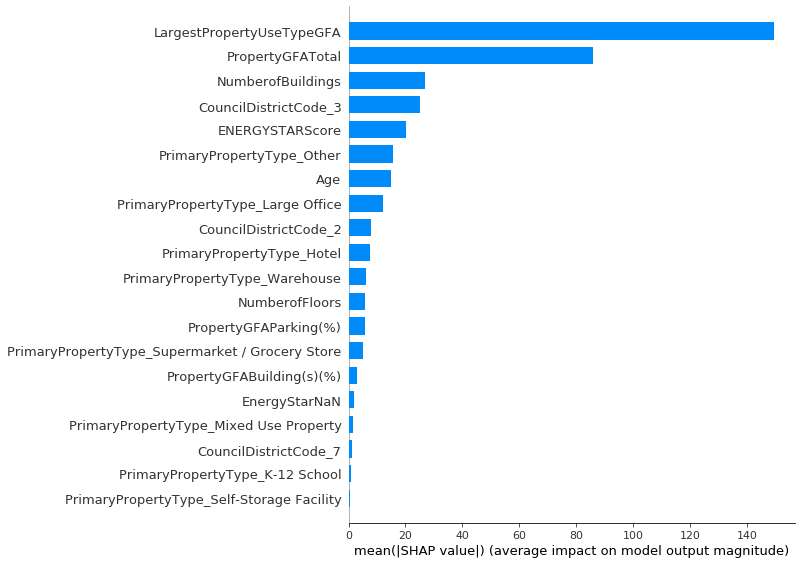

In [73]:
explainer = shap.TreeExplainer(gb, X_train)
shap_values = explainer.shap_values(X_test_tt, check_additivity=False)
shap.summary_plot(shap_values, X_test_tt, plot_type="bar")

In [74]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': gb.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
3,PropertyGFATotal,0.416434
6,LargestPropertyUseTypeGFA,0.189044
7,ENERGYSTARScore,0.066644
0,Age,0.052082
19,PrimaryPropertyType_Supermarket / Grocery Store,0.048216
2,NumberofFloors,0.037805
15,PrimaryPropertyType_Other,0.031042
10,PrimaryPropertyType_Hotel,0.027191
21,PrimaryPropertyType_Warehouse,0.025183
12,PrimaryPropertyType_Large Office,0.023057


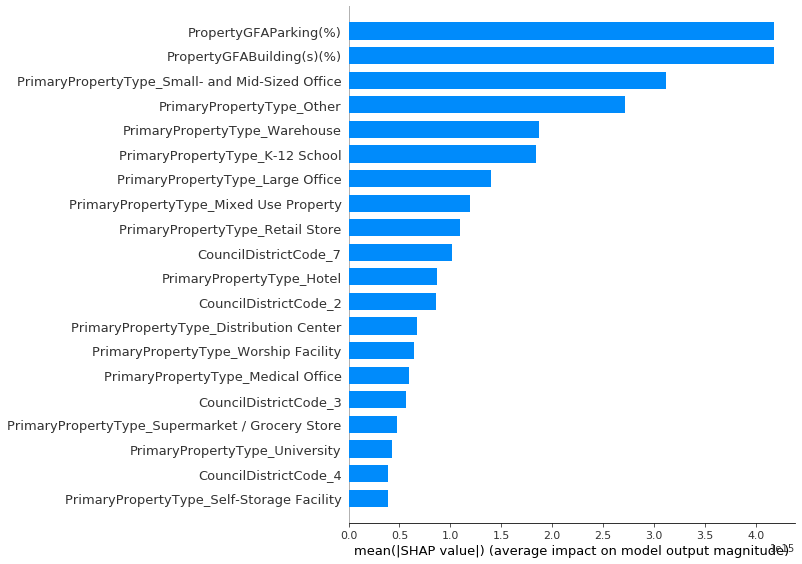

In [75]:
explainer_lr = shap.LinearExplainer(lr, X_train)
shap_values_lr = explainer_lr.shap_values(X_test)
shap.summary_plot(shap_values_lr, X_test, plot_type="bar")

In [76]:
explainer = shap.TreeExplainer(rf)

In [77]:
shap_values = shap.TreeExplainer(rf).shap_values(X_train)

In [78]:
shap_values

array([[-6.24928358, -6.81633479, -2.91370331, ..., -0.87478322,
        -0.17268831, -0.56457579],
       [17.72888284, -6.57558439,  3.26856595, ..., -0.13470424,
        -0.03552863, -0.38638136],
       [ 8.3992416 , -6.78554715, -3.23556017, ..., -0.09237373,
        -0.03552054, -0.20486631],
       ...,
       [ 1.21622681, -6.78921796, -4.46565142, ..., -0.08239357,
        -0.05962185,  1.18698852],
       [ 1.85522354, -7.09400696, -2.64501714, ..., -0.07463956,
        -0.0599098 , -0.40008184],
       [ 1.91293752, -6.834707  , -3.09249384, ..., -0.07303552,
        -0.0599098 , -0.48567158]])

In [79]:
np.clip(shap_values, 0, 100)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [17.72888284,  0.        ,  3.26856595, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.3992416 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.21622681,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.18698852],
       [ 1.85522354,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.91293752,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

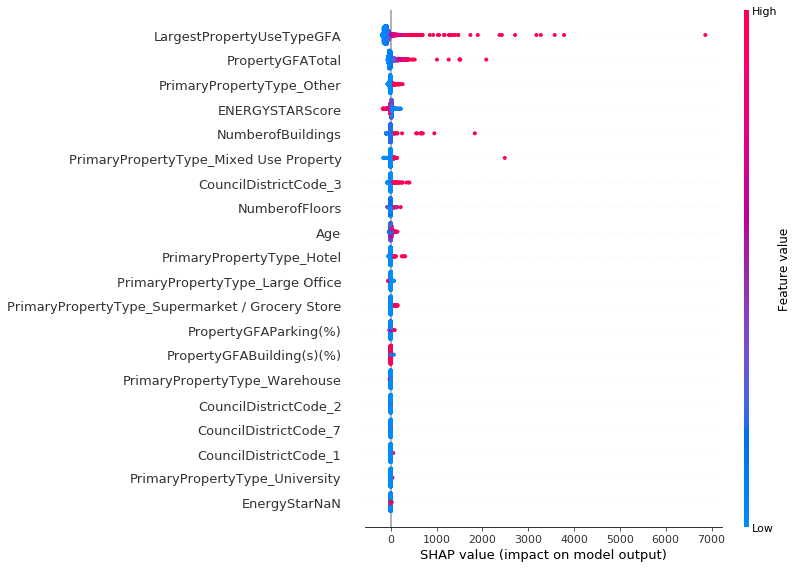

In [80]:
shap.summary_plot(shap_values, X_train)

In [81]:
shap.initjs()

In [82]:
i=5
shap.force_plot(explainer.expected_value, shap_values[i], 
                X_train.values[i], feature_names=X_train.columns)

In [86]:
X_train_tt_drop_ESS = X_train_tt.drop(['ENERGYSTARScore'], axis=1)
X_test_tt_drop_ESS = X_test_tt.drop(['ENERGYSTARScore'], axis=1)

In [92]:
tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_xgb.fit(X_train_tt_drop_ESS, y_train)
best_params_tt_xgb = grid_tt_xgb.best_params_
resultize(grid_tt_xgb).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
14,"{'regressor__learning_rate': 0.05, 'regressor_...",437.817636,1,342553.903379,1,119.719526,2,0.442438,1
13,"{'regressor__learning_rate': 0.05, 'regressor_...",441.924394,2,347230.539221,2,119.611519,1,0.440984,2
18,"{'regressor__learning_rate': 0.05, 'regressor_...",453.030485,3,358616.753087,4,120.360776,3,0.438262,3
12,"{'regressor__learning_rate': 0.05, 'regressor_...",453.994134,4,363374.123275,5,120.659932,5,0.419551,7
19,"{'regressor__learning_rate': 0.05, 'regressor_...",454.655689,5,358191.098952,3,121.028830,7,0.429212,5


In [94]:
best_params_tt_xgb = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}

In [98]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(**best_params_tt_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_xgb.fit(X_train_tt_drop_ESS, y_train)
y_pred = tt_xgb.predict(X_test_tt_drop_ESS)
tt_xgb_error_ESS = mean_squared_error(y_test, y_pred, squared=False)
tt_xgb_error_ESS

450.81027752786184

In [101]:
tt_xgb_error

387.6975445591075